# Imports

In [1]:
#根据https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb修改
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
sys.path.append("models/models/research/")
sys.path.append("models/models/research/slim/")
sys.path.append("models/models/research/object_detection/")

from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')


## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [3]:
from utils import label_map_util

from utils import visualization_utils as vis_util

models/models/research/object_detection/utils/visualization_utils.py:27: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  import matplotlib; matplotlib.use('Agg')  # pylint: disable=multiple-statements


# Model preparation 

In [4]:
# What model to download.
MODEL_NAME = 'faster_rcnn_resnet101_coco_2018_01_28'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = 'models/faster_rcnn_inception_v2_coco_2017_11_08/frozen_inference_graph.pb'
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'models/models/research/object_detection/data/mscoco_label_map.pbtxt'

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [5]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Helper code

In [6]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [7]:
import glob
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '../picture/objectdetect/adv-*'
#TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 2) ]
TEST_IMAGE_PATHS = glob.glob(PATH_TO_TEST_IMAGES_DIR)
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

print(TEST_IMAGE_PATHS)

['../picture/objectdetect/adv-case2.jpg', '../picture/objectdetect/adv-case1.jpg']


In [8]:
#定义类inference_model 封装对图像的预测能力
class inference_model():
    def __init__(self):
        self.graph = tf.Graph()
        self.sess = tf.Session(graph=self.graph)
        self.tensor_dict = {}
        
        self._make_model_and_ops()

    def _make_model_and_ops(self):
        
        with self.sess.graph.as_default():
        
            #image_tensor:0到输出之间存在无法计算梯度的op，因此需要直接操作Preprocessor/map/TensorArrayStack/TensorArrayGatherV3:0
            def create_graph(dirname):
                with tf.gfile.FastGFile(dirname, 'rb') as f:
                    graph_def = self.sess.graph_def
                    graph_def.ParseFromString(f.read())

                    _ = tf.import_graph_def(graph_def, name='')

            create_graph(PATH_TO_FROZEN_GRAPH)

            ops = self.sess.graph.get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}

            for key in [
                  'num_detections', 'detection_boxes', 'detection_scores',
                  'detection_classes', 'detection_masks',''
                  'SecondStagePostprocessor/convert_scores','SecondStagePostprocessor/scale_logits']:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    self.tensor_dict[key] = self.sess.graph.get_tensor_by_name(tensor_name)

            if 'detection_masks' in self.tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(self.tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(self.tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(self.tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                self.tensor_dict['detection_masks'] = tf.expand_dims(detection_masks_reframed, 0)
  

    def inference_draw(self,image):
        
        image_tensor = self.sess.graph.get_tensor_by_name('image_tensor:0')

        # Run inference
        output_dict = self.sess.run(self.tensor_dict,
                                 feed_dict={image_tensor: image})

        # all outputs are float32 numpy arrays, so convert types as appropriate
        output_dict['num_detections'] = int(output_dict['num_detections'][0])
        output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
        output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
        output_dict['detection_scores'] = output_dict['detection_scores'][0]
        
        if 'detection_masks' in output_dict:
            output_dict['detection_masks'] = output_dict['detection_masks'][0]

        # Visualization of the results of a detection.
        show_image_np=vis_util.visualize_boxes_and_labels_on_image_array(
              image_np.copy(),
              output_dict['detection_boxes'],
              output_dict['detection_classes'],
              output_dict['detection_scores'],
              category_index,
              instance_masks=output_dict.get('detection_masks'),
              use_normalized_coordinates=True,
              max_boxes_to_draw=5,
              min_score_thresh=0.2,
              line_thickness=2,
              skip_scores=False,
              skip_labels=False)


        plt.figure()
        plt.imshow(show_image_np)
        
        return output_dict


{'num_detections': 300,
 'detection_boxes': array([[0.3479308 , 0.4295833 , 0.67881197, 0.5360763 ],
        [0.36724097, 0.5163852 , 0.6523893 , 0.5927449 ],
        [0.45980695, 0.42365906, 0.76505333, 0.54931384],
        ...,
        [0.46784008, 0.50349945, 0.59417784, 0.5354549 ],
        [0.39292842, 0.44827443, 0.6091981 , 0.5314064 ],
        [0.7259161 , 0.4437371 , 0.77208525, 0.5075897 ]], dtype=float32),
 'detection_scores': array([9.51962411e-01, 9.51172709e-01, 9.23203647e-01, 5.50562859e-01,
        2.89769799e-01, 2.00684384e-01, 1.67048201e-01, 1.11666054e-01,
        9.29848105e-02, 7.96916634e-02, 6.70227930e-02, 6.41114041e-02,
        6.10547103e-02, 5.31968474e-02, 4.90290262e-02, 4.69768457e-02,
        4.07643728e-02, 2.97145601e-02, 2.93640643e-02, 2.83621103e-02,
        2.69438345e-02, 2.66865455e-02, 2.60783657e-02, 2.38282885e-02,
        2.37885788e-02, 2.19984353e-02, 2.05937885e-02, 2.01815069e-02,
        1.98918767e-02, 1.83165316e-02, 1.71786901e-02,

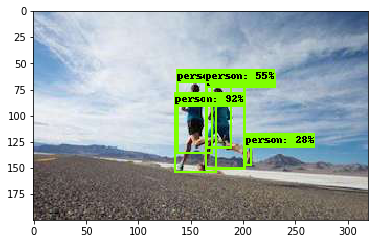

In [9]:
inference_model_instance=inference_model()

image_path="../picture/objectdetect/adv-case2.jpg"
image = Image.open(image_path).convert("RGB")
image=image.resize((320,200))

# the array based representation of the image will be used later in order to prepare the
# result image with boxes and labels on it.
image_np = load_image_into_numpy_array(image.copy())

inference_model_instance.inference_draw(np.expand_dims(image_np.copy(),0))

In [10]:
#定义类adv_model 封装生成对抗样本的功能
class adv_model():
    def __init__(self):
        self.graph = tf.Graph()
        self.sess = tf.Session(graph=self.graph)
        self.tensor_dict = {}
        self.patch_shape=(1, 200, 320, 3)
        self._make_model_and_ops()
            

    def _make_model_and_ops(self):
        
        with self.sess.graph.as_default():
            
            # Tensors are post-fixed with an underscore!
            self.image_input_ = tf.placeholder(tf.float32, shape=self.patch_shape, name='image_input_placeholder')
            self.patch_ = tf.get_variable('patch', self.patch_shape, dtype=tf.float32, initializer=tf.zeros_initializer)
            self.patch_placeholder_ = tf.placeholder(dtype=tf.float32, shape=self.patch_shape, name='patch_placeholder')
            self.assign_patch_ = tf.assign(self.patch_, self.patch_placeholder_)
                
            #self.clipped_patch_ = tf.tanh(patch_)
            patched_input_ = self.patch_+self.image_input_/255.0
            #patched_input_ = self.clipped_patch_+self.image_input_placeholder
            #高级阶段函数 可以结算梯度
            #This operation has a gradient and thus allows for training min and max values.
            #https://tensorflow.google.cn/api_docs/python/tf/quantization/fake_quant_with_min_max_vars
            self.patched_input_ = tf.fake_quant_with_min_max_vars(patched_input_*255.0, min=0, max=255)
            
            # Create placeholders for NMS RPN inputs
            self.rpn_nms_bboxes_placeholder_ = tf.placeholder(tf.float32, shape=(None, 4), name='rpn_nms_bboxes')
            self.rpn_nms_indices_placeholder_ = tf.placeholder(tf.int32, shape=(None), name='rpn_nms_indices')
            
            
            #image_tensor:0到输出之间存在无法计算梯度的op，因此需要直接操作Preprocessor/map/TensorArrayStack/TensorArrayGatherV3:0
            def create_graph(dirname):
                with tf.gfile.FastGFile(dirname, 'rb') as f:
                    graph_def = self.sess.graph_def
                    graph_def.ParseFromString(f.read())

                    _ = tf.import_graph_def(graph_def, name='adv_model',
                       input_map={
                           'Preprocessor/map/TensorArrayStack/TensorArrayGatherV3:0':self.patched_input_,
                           'Reshape_7:0':self.rpn_nms_bboxes_placeholder_,
                           'Reshape_8:0':self.rpn_nms_indices_placeholder_
                           }
                                           )

            create_graph(PATH_TO_FROZEN_GRAPH) 
            
            # Recreate tensors we just replaced in the input_map
            self.rpn_nms_bboxes_ = tf.reshape( self.graph.get_tensor_by_name('adv_model/Reshape_6:0'), 
                                              self.graph.get_tensor_by_name('adv_model/stack_3:0'), 
                                              name='adv_model/Reshape_7')
            self.rpn_nms_indices_ = tf.reshape(self.graph.get_tensor_by_name('adv_model/mul_1:0'), 
                                               self.graph.get_tensor_by_name('adv_model/Reshape_8/shape:0'),
                                               name='adv_model/Reshape_8') 

            # Second-stage Class Loss
            self.second_stage_cls_scores_ = self.graph.get_tensor_by_name('adv_model/SecondStagePostprocessor/convert_scores:0')
            second_stage_cls_logits_ = self.graph.get_tensor_by_name('adv_model/SecondStagePostprocessor/scale_logits:0')
            self.second_stage_cls_labels_ = tf.placeholder(tf.float32, shape=second_stage_cls_logits_.shape, name='second_stage_cls_labels')
            second_stage_cls_losses_ = tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.reshape(self.second_stage_cls_labels_, (-1, self.second_stage_cls_labels_.shape[2])),
                                                                                      logits=tf.reshape(second_stage_cls_logits_, (-1, second_stage_cls_logits_.shape[2]))) 
            second_stage_cls_losses_ = tf.reshape(second_stage_cls_losses_, (-1, self.second_stage_cls_labels_.shape[1]))
            second_stage_cls_losses_ = tf.divide(second_stage_cls_losses_, tf.to_float(self.second_stage_cls_labels_.shape[1]))
            self.second_stage_cls_loss_ = tf.reduce_sum(second_stage_cls_losses_)
            
            
            # Second-stage bounding boxes
            self.second_stage_loc_bboxes_ = self.graph.get_tensor_by_name('adv_model/SecondStagePostprocessor/Reshape_4:0')
           
            # Sum of weighted losses
            self.loss_ = self.second_stage_cls_loss_

            # Train our attack by only training on the patch variable
            #self.train_op_ = tf.train.GradientDescentOptimizer(0.1).minimize(self.loss_, var_list=[patch_])
            self.train_op_ = tf.train.AdamOptimizer(0.01).minimize(self.loss_, var_list=[self.patch_])
            
            # 初始化参数  非常重要 Adam的参数也需要这样初始化 GradientDescent可以省略这一步
            self.sess.run(tf.global_variables_initializer())
                
            #初始化
            self.sess.run(self.assign_patch_, {self.patch_placeholder_: np.zeros(self.patch_shape)})

    def inference_rpn(self, images):
        feed_dict = { self.image_input_: images }
        
        tensors = [self.rpn_nms_bboxes_,
                   self.rpn_nms_indices_ ]

        rpn_nms_bboxes, rpn_nms_indices = self.sess.run(tensors, feed_dict)
        
        return rpn_nms_bboxes, rpn_nms_indices

    #预测并绘图
    def inference_draw(self, images):

        patched_imgs, second_stage_cls_scores, second_stage_loc_bboxes = self.inference(images)
        patched_imgs = patched_imgs.astype(np.uint8)
        
        
        scores = second_stage_cls_scores[0]
        bboxes = second_stage_loc_bboxes[0]
        
        sorted_classes = np.argsort(scores[:, 1:], axis=1)
        sorted_scores = scores[:, 1:].copy()
        sorted_bboxes = bboxes.copy()
        
        
        print("sorted_classes")
        print(sorted_classes.shape)
        print(sorted_classes)

        for i, ordering in enumerate(sorted_classes):
            sorted_scores[i, :] = scores[i, ordering+1]
            sorted_bboxes[i, :] = bboxes[i, ordering, :]

        sorted_classes += 1

        
        
        # Visualization of the results of a detection.
        show_image_np=vis_util.visualize_boxes_and_labels_on_image_array(
              patched_imgs[0].copy(),
              sorted_bboxes[:, -1, :],
              sorted_classes[:, -1].astype(np.int32),
              sorted_scores[:, -1],
              category_index,
              use_normalized_coordinates=False,
              max_boxes_to_draw=5,
              min_score_thresh=0.2,
              line_thickness=2,
              skip_scores=False,
              skip_labels=False)


        plt.figure()
        plt.imshow(show_image_np)
        
 
        return None
        

    def inference(self, images):
        rpn_nms_bboxes, rpn_nms_indices = self.inference_rpn(images)

        feed_dict = { self.image_input_: images,
                      self.rpn_nms_bboxes_placeholder_: rpn_nms_bboxes,
                      self.rpn_nms_indices_placeholder_: rpn_nms_indices }

        tensors = [ self.patched_input_,
                    self.second_stage_cls_scores_,
                    self.second_stage_loc_bboxes_ ]

        patched_imgs, second_stage_cls_scores, second_stage_loc_bboxes = self.sess.run(tensors, feed_dict)
        patched_imgs = patched_imgs.astype(np.uint8)
        
        return patched_imgs, second_stage_cls_scores, second_stage_loc_bboxes   

    
    
    def train_step(self, images, second_stage_cls_labels):
        
        rpn_nms_bboxes, rpn_nms_indices = self.inference_rpn(images)
        
        feed_dict = { 
                      self.image_input_: images,
                      self.second_stage_cls_labels_: second_stage_cls_labels,
                      self.rpn_nms_bboxes_placeholder_: rpn_nms_bboxes,
                      self.rpn_nms_indices_placeholder_: rpn_nms_indices, }
        
        
        tensors = [ self.train_op_,
                    self.loss_]

        train_op, loss= self.sess.run(tensors, feed_dict)

        return loss
    
    def get_patch(self):
        
        patch=self.sess.run(self.patch_)
        patch = np.round(patch[0]*255.0).astype(np.uint8)
        
        return patch


In [11]:
adv_model_instance=adv_model()

#从person 1 变为horse 19 
TARGET_CLASS = 19 
FROM_CLASS = 1 

def create_target_labels(scores, from_class, to_class):
    target_labels = np.zeros_like(scores)
    classes = np.argmax(scores[:, :, 1:], axis=2)+1
    #print(classes)
    
    for i, _ in enumerate(classes):
        for j, cls in enumerate(classes[i]):
            cls = to_class # Just perturb all of them!
            target_labels[i, j, cls] = 1

    return target_labels

_, scores, _  = adv_model_instance.inference( np.expand_dims(image_np.copy(),0) )
#print(scores)
#print(scores.shape)

target_labels = create_target_labels(scores, FROM_CLASS, TARGET_CLASS)
#print(target_labels.shape)

epoch=0 loss=13.519378662109375
sorted_classes
(300, 90)
[[44 74 70 ... 61 18  0]
 [44 25 82 ... 30 26  0]
 [74 76 70 ... 61 18  0]
 ...
 [82 29 28 ...  4 61  2]
 [65 82 25 ... 21 15  0]
 [70 29 65 ... 61 66 14]]
epoch=50 loss=0.586590051651001
sorted_classes
(300, 90)
[[86 48 53 ... 19 20 18]
 [86 73 48 ... 19 20 18]
 [73 48 53 ...  0 20 18]
 ...
 [73 67 28 ... 19 20 18]
 [72 65 53 ... 20 21 18]
 [65 11 67 ...  0 21 20]]
epoch=100 loss=0.23193860054016113
sorted_classes
(300, 90)
[[86 48 73 ...  0 20 18]
 [74 86 73 ...  0 20 18]
 [73 74 53 ... 20  0 18]
 ...
 [73 53 76 ... 19 20 18]
 [65 72 75 ... 19  0 18]
 [73 76 28 ...  1  0 18]]
epoch=150 loss=0.1585366129875183
sorted_classes
(300, 90)
[[48 86 73 ... 19 20 18]
 [73 48 74 ... 19 20 18]
 [73 48 60 ... 19 20 18]
 ...
 [73 67 44 ... 19 20 18]
 [73 53 67 ... 19 20 18]
 [73 74 75 ... 19 20 18]]
epoch=200 loss=0.09822837263345718
sorted_classes
(300, 90)
[[48 86 60 ... 19 20 18]
 [74 86 48 ... 20  0 18]
 [73 48 70 ... 19 20 18]
 ...
 [8

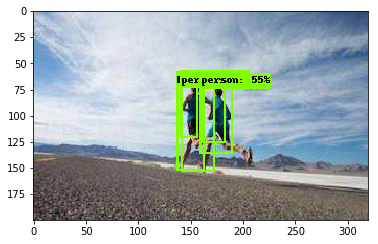

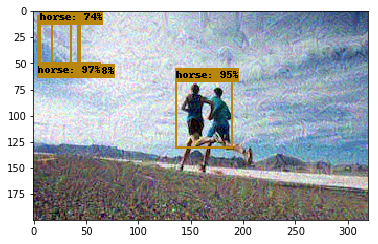

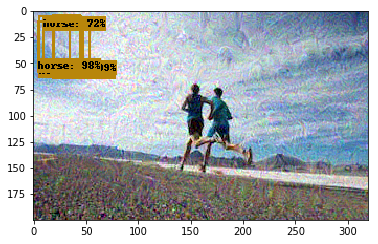

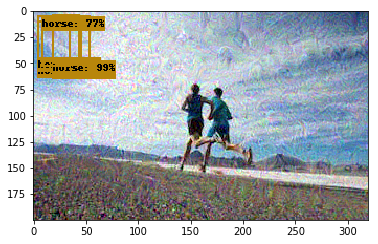

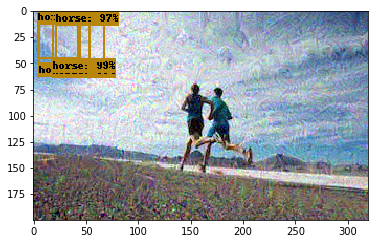

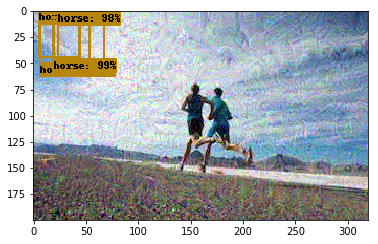

In [12]:
#开始迭代求解
epochs=300

for epoch in range(epochs):
    loss = adv_model_instance.train_step(np.expand_dims(image_np.copy(),0),target_labels)
    
    
    #显示中间结果
    if (epoch % 50) == 0:  
        print("epoch={} loss={}".format(epoch,loss))
        adv_model_instance.inference_draw(np.expand_dims(image_np.copy(),0))
